# Model Building 

* Using Custom Transformer(s)
* Open Source libraries
* Pipeline

In [1]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.
    Args:
    -----
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.
    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)
    

In [2]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Binarizer
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

# ML Algos
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer,
)

from feature_engine.discretisation import EqualFrequencyDiscretiser

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

# Custom Module(s)
go_up_from_current_directory(go_up=1)
import preprocessor as pp
import utilities
from lending_data import LendingData

# Built-in library
import itertools
import re
import json
import typing as tp

# pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

/Users/neidu/Desktop/Projects/Personal/tutorials/LendingClub Issued Loans


In [3]:
fp = "../data/lc_2016_2017.csv"  # Filepath
# columns_to_drop = ["id", "member_id", "desc", "policy_code"]

orig_data = utilities.load_data(filepath=fp, format_="csv", low_memory=False)
# orig_data.drop(columns=columns_to_drop, inplace=True)

orig_data.head(10)

The shape of the data: (759338, 72)



,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,112435993,NaN,2300,2300,2300.0,36 months,12.62,77.08,C,C1,NaN,NaN,OWN,10000.00,Not Verified,Jun-2017,Current,n,NaN,credit_card,Credit card refinancing,148xx,NY,21.61,0,Sep-1985,1.0,NaN,NaN,4,0,3911.0,55.1,6,w,2029.91,2029.91,382.990000,382.99,270.09,112.90,0.0,0.0,0.0,Dec-2017,77.08,Jan-2018,Dec-2017,0,NaN,1,Individual,NaN,NaN,NaN,0,0.0,3911.0,0.0,0.0,0.0,NaN,0.0,NaN,1.0,2.0,2315.0,55.0,7100.0,1.0,0.0,2.0
1,112290210,NaN,16000,16000,16000.0,60 months,12.62,360.95,C,C1,teacher,10+ years,MORTGAGE,94000.00,Not Verified,Jun-2017,Current,n,NaN,debt_consolidation,Debt consolidation,021xx,MA,25.61,0,Jun-1992,0.0,NaN,NaN,9,0,33752.0,105.8,26,w,14813.07,14813.07,2060.090000,2060.09,1186.93,873.16,0.0,0.0,0.0,Dec-2017,360.95,Jan-2018,Dec-2017,0,NaN,1,Individual,NaN,NaN,NaN,0,0.0,234457.0,2.0,0.0,0.0,26.0,11078.0,69.0,3.0,5.0,1962.0,94.0,31900.0,0.0,6.0,1.0
2,112436985,NaN,6025,6025,6025.0,36 months,15.05,209.01,C,C4,Front Office,7 years,MORTGAGE,46350.00,Not Verified,Jun-2017,Current,n,NaN,home_improvement,Home improvement,018xx,MA,8.88,0,Jun-2002,0.0,NaN,NaN,11,0,12425.0,44.9,27,w,5340.82,5340.82,1032.460000,1032.46,684.18,348.28,0.0,0.0,0.0,Dec-2017,209.01,Jan-2018,Dec-2017,0,NaN,1,Individual,NaN,NaN,NaN,0,0.0,121311.0,1.0,1.0,2.0,10.0,0.0,NaN,1.0,2.0,1950.0,45.0,27700.0,1.0,5.0,3.0
3,112439006,NaN,20400,20400,20400.0,36 months,9.44,652.91,B,B1,Manager,10+ years,RENT,44000.00,Source Verified,Jun-2017,Current,n,NaN,car,Car financing,913xx,CA,27.06,0,Jan-2007,1.0,NaN,NaN,15,0,8769.0,18.7,19,w,17898.81,17898.81,3237.800000,3237.80,2501.19,736.61,0.0,0.0,0.0,Dec-2017,652.91,Jan-2018,Dec-2017,0,NaN,1,Individual,NaN,NaN,NaN,0,0.0,62335.0,1.0,1.0,1.0,6.0,53566.0,95.0,1.0,2.0,4240.0,60.0,46900.0,1.0,1.0,1.0
4,112438929,NaN,13000,13000,13000.0,36 months,11.99,431.73,B,B5,Paramedic,10+ years,MORTGAGE,85000.00,Source Verified,Jun-2017,Current,n,NaN,debt_consolidation,Debt consolidation,560xx,MN,6.79,1,Feb-2002,0.0,16.0,NaN,5,0,6866.0,88.0,24,w,11460.66,11460.66,2137.000000,2137.00,1539.34,597.66,0.0,0.0,0.0,Dec-2017,431.73,Jan-2018,Dec-2017,0,16.0,1,Individual,NaN,NaN,NaN,0,0.0,15332.0,0.0,0.0,0.0,127.0,8466.0,72.0,0.0,1.0,2996.0,78.0,7800.0,0.0,0.0,0.0
5,112230200,NaN,12000,12000,12000.0,36 months,9.44,384.06,B,B1,Teacher,10+ years,MORTGAGE,70000.00,Not Verified,Jun-2017,Current,n,NaN,debt_consolidation,Debt consolidation,184xx,PA,18.34,0,Aug-1997,0.0,35.0,83.0,14,1,15025.0,58.2,30,w,10528.73,10528.73,1904.570000,1904.57,1471.27,433.30,0.0,0.0,0.0,Dec-2017,384.06,Jan-2018,Dec-2017,0,NaN,1,Individual,NaN,NaN,NaN,0,0.0,211227.0,0.0,0.0,0.0,41.0,12438.0,40.0,2.0,3.0,5227.0,49.0,25800.0,0.0,0.0,2.0
6,112210041,NaN,6000,6000,6000.0,36 months,10.42,194.79,B,B3,Office Clerk,7 years,MORTGAGE,37107.19,Source Verified,Jun-2017,Current,n,NaN,medical,Medical expenses,773xx,TX,30.63,0,Mar-1992,0.0,70.0,71.0,10,1,9332.0,59.1,28,w,5274.05,5274.05,965.270000,965.27,725.95,239.32,0.0,0.0,0.0,Dec-2017,194.79,Jan-2018,Dec-2017,0,NaN,1,Individual,NaN,NaN,NaN,0,275.0,107517.0,0.0,0.0,1.0,19.0,19983.0,NaN,1.0,1.0,3990.0,59.0,15800.0,0.0,0.0,0.0
7

In [4]:
num_vars_to_drop = [
    LendingData.FUNDED_AMNT,
    LendingData.FUNDED_AMNT_INV,
    LendingData.ID,
    LendingData.INSTALLMENT,
    LendingData.TOTAL_PYMNT_INV,
    LendingData.TOTAL_REC_PRNCP,
    LendingData.OUT_PRNCP_INV,
    LendingData.COLLECTION_RECOVERY_FEE,
    LendingData.OPEN_RV_24M,
]

cat_vars_to_drop = [
    LendingData.EMP_TITLE,
    LendingData.ISSUE_D,
    LendingData.LAST_PYMNT_D,
    LendingData.NEXT_PYMNT_D,
    LendingData.LAST_CREDIT_PULL_D,
    LendingData.SUB_GRADE,
    LendingData.TITLE,
    LendingData.EARLIEST_CR_LINE,
    LendingData.PYMNT_PLAN,
    LendingData.MEMBER_ID,
    LendingData.DESC,
    LendingData.POLICY_CODE,
]

# Drop the variables
orig_data.drop(columns=num_vars_to_drop + cat_vars_to_drop, inplace=True)

In [5]:
## ====== CONFIGS ======
TARGET = LendingData.LOAN_STATUS
TEST_SIZE = 0.1
RANDOM_STATE = 123

In [6]:
# These labels will be treated as default
default_list = [
    "Charged Off",
    "Late (31-120 days)",
    "Default",
    "Does not meet the credit policy. Status:Charged Off",
]

# Update the loan_status
orig_data[TARGET] = orig_data[TARGET].apply(
    lambda status: 1 if status in default_list else 0
)

# Check the frequency table of the target
orig_data[TARGET].value_counts(normalize=True)

0    0.930746
1    0.069254
Name: loan_status, dtype: float64

In [7]:
# Split the data
X = orig_data.drop(columns=[TARGET])
y = orig_data[TARGET]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

## Pipeline Configs

In [8]:
# Numerical variables with NA in train set
NUMERICAL_VARS_WITH_NA = [
    LendingData.DTI,
    LendingData.INQ_LAST_6MTHS,
    LendingData.MTHS_SINCE_LAST_DELINQ,
    LendingData.MTHS_SINCE_LAST_RECORD,
    LendingData.REVOL_UTIL,
    LendingData.MTHS_SINCE_LAST_MAJOR_DEROG,
    LendingData.ANNUAL_INC_JOINT,
    LendingData.DTI_JOINT,
    LendingData.OPEN_ACC_6M,
    LendingData.OPEN_IL_12M,
    LendingData.OPEN_IL_24M,
    LendingData.MTHS_SINCE_RCNT_IL,
    LendingData.TOTAL_BAL_IL,
    LendingData.IL_UTIL,
    LendingData.OPEN_RV_12M,
    LendingData.MAX_BAL_BC,
    LendingData.ALL_UTIL,
    LendingData.INQ_FI,
    LendingData.TOTAL_CU_TL,
    LendingData.INQ_LAST_12M,
]

# Categorical variables with NA in train set
CATEGORICAL_VARS_WITH_NA_FREQUENT = [LendingData.EMP_LENGTH, LendingData.ZIP_CODE]
CATEGORICAL_VARS_WITH_NA_MISSING = [LendingData.VERIFICATION_STATUS_JOINT]

# Numerical variables to replace with median in train set
REPL_VARS_WITH_MEDIAN = [
    LendingData.DTI,
    LendingData.INQ_LAST_6MTHS,
    LendingData.MTHS_SINCE_LAST_DELINQ,
    LendingData.MTHS_SINCE_LAST_MAJOR_DEROG,
    LendingData.ANNUAL_INC_JOINT,
    LendingData.ALL_UTIL,
]
# Numerical variables to replace with median in train set
REPL_VARS_WITH_MEAN = [
    LendingData.MTHS_SINCE_LAST_RECORD,
    LendingData.REVOL_UTIL,
    LendingData.DTI_JOINT,
    LendingData.OPEN_ACC_6M,
    LendingData.OPEN_IL_12M,
    LendingData.OPEN_IL_24M,
    LendingData.MTHS_SINCE_RCNT_IL,
    LendingData.TOTAL_BAL_IL,
    LendingData.IL_UTIL,
    LendingData.OPEN_RV_12M,
    LendingData.MAX_BAL_BC,
    LendingData.INQ_FI,
    LendingData.TOTAL_CU_TL,
    LendingData.INQ_LAST_12M,
]

# Numerical variables to transform with log_transformation in train set
LOG_TRANSFORMED_VARS = [LendingData.TOTAL_ACC, LendingData.INT_RATE]
# Numerical variables to transform with yea_johnson_transformation in train set
YEO_JOHNSON_TRANSFORMED_VARS = [
    LendingData.TOTAL_REV_HI_LIM,
    LendingData.OPEN_ACC,
    LendingData.MTHS_SINCE_RCNT_IL,
    LendingData.MTHS_SINCE_LAST_DELINQ,
    LendingData.IL_UTIL,
    LendingData.TOT_CUR_BAL,
    LendingData.TOTAL_PYMNT,
    LendingData.TOTAL_BAL_IL,
    LendingData.REVOL_BAL,
    LendingData.MTHS_SINCE_LAST_MAJOR_DEROG,
    LendingData.TOTAL_REC_INT,
    LendingData.MAX_BAL_BC,
    LendingData.LAST_PYMNT_AMNT,
]

# Numerical variables to discretize in train set
NUMERICAL_VARS_TO_BIN = [
    LendingData.ANNUAL_INC,
    LendingData.ANNUAL_INC_JOINT,
    LendingData.PUB_REC,
    LendingData.MTHS_SINCE_LAST_RECORD,
    LendingData.DELINQ_2YRS,
    LendingData.OPEN_IL_24M,
    LendingData.OPEN_RV_12M,
    LendingData.TOT_COLL_AMT,
    LendingData.INQ_FI,
    LendingData.RECOVERIES,
    LendingData.INQ_LAST_12M,
    LendingData.TOTAL_CU_TL,
    LendingData.TOTAL_REC_LATE_FEE,
    LendingData.DTI,
    LendingData.DTI_JOINT,
    LendingData.OUT_PRNCP,
]

# Variable(s) to map
MAPPING_VARS = [LendingData.EMP_LENGTH]
EMP_LENGTH_MAPPINGS = {
    "10+ years": "10",
    "2 years": "2",
    "< 1 year": "0",
    "3 years": "3",
    "1 year": "1",
    "5 years": "5",
    "4 years": "4",
    "6 years": "6",
    "8 years": "8",
    "9 years": "9",
    "7 years": "7",
}

NUMERICAL_VARS = [
    LendingData.LOAN_AMNT,
    LendingData.INT_RATE,
    LendingData.ANNUAL_INC,
    LendingData.DTI,
    LendingData.DELINQ_2YRS,
    LendingData.INQ_LAST_6MTHS,
    LendingData.MTHS_SINCE_LAST_DELINQ,
    LendingData.MTHS_SINCE_LAST_RECORD,
    LendingData.OPEN_ACC,
    LendingData.PUB_REC,
    LendingData.REVOL_BAL,
    LendingData.REVOL_UTIL,
    LendingData.TOTAL_ACC,
    LendingData.OUT_PRNCP,
    LendingData.TOTAL_PYMNT,
    LendingData.TOTAL_REC_INT,
    LendingData.TOTAL_REC_LATE_FEE,
    LendingData.RECOVERIES,
    LendingData.LAST_PYMNT_AMNT,
    LendingData.COLLECTIONS_12_MTHS_EX_MED,
    LendingData.MTHS_SINCE_LAST_MAJOR_DEROG,
    LendingData.ANNUAL_INC_JOINT,
    LendingData.DTI_JOINT,
    LendingData.ACC_NOW_DELINQ,
    LendingData.TOT_COLL_AMT,
    LendingData.TOT_CUR_BAL,
    LendingData.OPEN_ACC_6M,
    LendingData.OPEN_IL_12M,
    LendingData.OPEN_IL_24M,
    LendingData.MTHS_SINCE_RCNT_IL,
    LendingData.TOTAL_BAL_IL,
    LendingData.IL_UTIL,
    LendingData.OPEN_RV_12M,
    LendingData.MAX_BAL_BC,
    LendingData.ALL_UTIL,
    LendingData.TOTAL_REV_HI_LIM,
    LendingData.INQ_FI,
    LendingData.TOTAL_CU_TL,
    LendingData.INQ_LAST_12M,
]

CONTINUOUS_VARS = [
    LendingData.LOAN_AMNT,
    LendingData.INT_RATE,
    LendingData.ANNUAL_INC,
    LendingData.DTI,
    LendingData.DELINQ_2YRS,
    LendingData.MTHS_SINCE_LAST_DELINQ,
    LendingData.MTHS_SINCE_LAST_RECORD,
    LendingData.OPEN_ACC,
    LendingData.PUB_REC,
    LendingData.REVOL_BAL,
    LendingData.REVOL_UTIL,
    LendingData.TOTAL_ACC,
    LendingData.OUT_PRNCP,
    LendingData.TOTAL_PYMNT,
    LendingData.TOTAL_REC_INT,
    LendingData.TOTAL_REC_LATE_FEE,
    LendingData.RECOVERIES,
    LendingData.LAST_PYMNT_AMNT,
    LendingData.MTHS_SINCE_LAST_MAJOR_DEROG,
    LendingData.ANNUAL_INC_JOINT,
    LendingData.DTI_JOINT,
    LendingData.TOT_COLL_AMT,
    LendingData.TOT_CUR_BAL,
    LendingData.OPEN_IL_24M,
    LendingData.MTHS_SINCE_RCNT_IL,
    LendingData.TOTAL_BAL_IL,
    LendingData.IL_UTIL,
    LendingData.OPEN_RV_12M,
    LendingData.MAX_BAL_BC,
    LendingData.ALL_UTIL,
    LendingData.TOTAL_REV_HI_LIM,
    LendingData.INQ_FI,
    LendingData.TOTAL_CU_TL,
    LendingData.INQ_LAST_12M,
]

DISCRETE_VARS = [
    LendingData.INQ_LAST_6MTHS,
    LendingData.COLLECTIONS_12_MTHS_EX_MED,
    LendingData.ACC_NOW_DELINQ,
    LendingData.OPEN_ACC_6M,
    LendingData.OPEN_IL_12M,
]

CATEGORICAL_VARS = [
    LendingData.TERM,
    LendingData.GRADE,
    LendingData.EMP_LENGTH,
    LendingData.HOME_OWNERSHIP,
    LendingData.VERIFICATION_STATUS,
    LendingData.PURPOSE,
    LendingData.ZIP_CODE,
    LendingData.ADDR_STATE,
    LendingData.INITIAL_LIST_STATUS,
    LendingData.APPLICATION_TYPE,
    LendingData.VERIFICATION_STATUS_JOINT,
]

In [9]:
sample_list = [
    "dti",
    "inq_last_6mths",
    "mths_since_last_delinq",
    "mths_since_last_major_derog",
    "annual_inc_joint",
    "all_util",
]

result = utilities.obtain_mapped_variables(
    data=orig_data, input_list=sample_list, name="LendingData"
)
print(result)

[LendingData.DTI, LendingData.INQ_LAST_6MTHS, LendingData.MTHS_SINCE_LAST_DELINQ, LendingData.MTHS_SINCE_LAST_MAJOR_DEROG, LendingData.ANNUAL_INC_JOINT, LendingData.ALL_UTIL]


### Workflow

* Handle missing data
    * Numerical data: Create a missing indicator and replace NaNs with mean/median.
    * Categorical data: Replace NaNs with missing/most frequent label.
* Transform numerical data: log and yeo_johnson transformations.
* Discretize numerical data (highly skewed data).
* Clean categorical data.
* Remove rare labels (categorical and discrete data).
* Encode data (categorical and discrete data).
* Scale data

<br><hr>

## Build Pipeline For Feature Engineering And Model Building

In [10]:
# Visualize Pipelines
from sklearn import set_config

set_config(display="diagram")

In [11]:
logistic_pipe = Pipeline(
    steps=[
        # ========== IMPUTATION ==========
        # add missing indicator
        ("missing_indicator", AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)),
        # Impute numerical variables with the median
        (
            "median_imputation",
            MeanMedianImputer(
                imputation_method="median", variables=REPL_VARS_WITH_MEDIAN
            ),
        ),
        # Impute numerical variables with the mean
        (
            "mean_imputation",
            MeanMedianImputer(imputation_method="mean", variables=REPL_VARS_WITH_MEAN),
        ),
        # Impute categorical variables with string missing
        (
            "missing_imputation",
            CategoricalImputer(
                imputation_method="missing", variables=CATEGORICAL_VARS_WITH_NA_MISSING
            ),
        ),
        (
            "frequent_imputation",
            CategoricalImputer(
                imputation_method="frequent",
                variables=CATEGORICAL_VARS_WITH_NA_FREQUENT,
            ),
        ),
        # ========== TRANSFORM NUMERICAL VARIABLES ==========
        (
            "log_transform",
            LogTransformer(variables=LOG_TRANSFORMED_VARS),
        ),
        (
            "yeo_johnson_transform",
            YeoJohnsonTransformer(
                variables=YEO_JOHNSON_TRANSFORMED_VARS + NUMERICAL_VARS_TO_BIN
            ),
        ),
        # ========== DISCRETIZE NUMERICAL VARIABLES ==========
        (
            "discretizer",
            EqualFrequencyDiscretiser(
                variables=DISCRETE_VARS,
                q=10,
                return_object=True,
            ),
        ),
        # ========== CLEAN CATEGORICAL VARIABLES ==========
        (
            "emp_length_mapper",
            pp.Mapper(variables=MAPPING_VARS, mappings=EMP_LENGTH_MAPPINGS),
        ),
        # ========== REMOVE RARE LABELS ==========
        (
            "rare_labels",
            RareLabelEncoder(
                tol=0.05, n_categories=5, variables=CATEGORICAL_VARS + DISCRETE_VARS
            ),
        ),
        # ========== ENCODE CATEGORICAL VARIABLES ==========
        (
            "categorical_encoder",
            OrdinalEncoder(
                encoding_method="ordered", variables=CATEGORICAL_VARS + DISCRETE_VARS
            ),
        ),
        # ========== SCALE VARIABLES ==========
        (
            "scaler",
            StandardScaler(),
        ),
        # ========== LOGISTIC MODEL ==========
        (
            "log_model",
            LogisticRegression(),
        ),
    ]
)
logistic_pipe

Pipeline(steps=[('missing_indicator',
                 AddMissingIndicator(variables=['dti', 'inq_last_6mths',
                                                'mths_since_last_delinq',
                                                'mths_since_last_record',
                                                'revol_util',
                                                'mths_since_last_major_derog',
                                                'annual_inc_joint', 'dti_joint',
                                                'open_acc_6m', 'open_il_12m',
                                                'open_il_24m',
                                                'mths_since_rcnt_il',
                                                'total_bal_il', 'il_util',
                                                'open_rv_12m', 'max_bal_bc',
                                                'all_util', 'inq_fi',...
                 OrdinalEncoder(variables=['term', 'grade', 'emp_length',
                                           'home_ownership',
                                           'verification_status', 'purpose',
                                           'zip_code', 'addr_state',
                                           'initial_list_status',
                                           'application_type',
                                           'verification_status_joint',
                                           'inq_last_6mths',
                                           'collections_12_mths_ex_med',
                                           'acc_now_delinq', 'open_acc_6m',
                                           'open_il_12m'])),
                ('scaler', StandardScaler()),
                ('log_model', LogisticRegression())])

In [12]:
# Train the pipeline
logistic_pipe.fit(X_train, y_train)

/Users/neidu/miniconda3/envs/ds/lib/python3.9/site-packages/scipy/stats/_morestats.py:1558: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
/Users/neidu/miniconda3/envs/ds/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2323: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/neidu/miniconda3/envs/ds/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2324: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
/Users/neidu/miniconda3/envs/ds/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2322: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/neidu/miniconda3/envs/ds/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2321: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Users/neidu/miniconda3/envs/ds/lib/python3.9/site-packages/fe

Pipeline(steps=[('missing_indicator',
                 AddMissingIndicator(variables=['dti', 'inq_last_6mths',
                                                'mths_since_last_delinq',
                                                'mths_since_last_record',
                                                'revol_util',
                                                'mths_since_last_major_derog',
                                                'annual_inc_joint', 'dti_joint',
                                                'open_acc_6m', 'open_il_12m',
                                                'open_il_24m',
                                                'mths_since_rcnt_il',
                                                'total_bal_il', 'il_util',
                                                'open_rv_12m', 'max_bal_bc',
                                                'all_util', 'inq_fi',...
                 OrdinalEncoder(variables=['term', 'grade', 'emp_length',
                                           'home_ownership',
                                           'verification_status', 'purpose',
                                           'zip_code', 'addr_state',
                                           'initial_list_status',
                                           'application_type',
                                           'verification_status_joint',
                                           'inq_last_6mths',
                                           'collections_12_mths_ex_med',
                                           'acc_now_delinq', 'open_acc_6m',
                                           'open_il_12m'])),
                ('scaler', StandardScaler()),
                ('log_model', LogisticRegression())])

In [13]:
sgd_pipe = Pipeline(
    steps=[
        # ========== IMPUTATION ==========
        # add missing indicator
        ("missing_indicator", AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)),
        # Impute numerical variables with the median
        (
            "median_imputation",
            MeanMedianImputer(
                imputation_method="median", variables=REPL_VARS_WITH_MEDIAN
            ),
        ),
        # Impute numerical variables with the mean
        (
            "mean_imputation",
            MeanMedianImputer(imputation_method="mean", variables=REPL_VARS_WITH_MEAN),
        ),
        # Impute categorical variables with string missing
        (
            "missing_imputation",
            CategoricalImputer(
                imputation_method="missing", variables=CATEGORICAL_VARS_WITH_NA_MISSING
            ),
        ),
        (
            "frequent_imputation",
            CategoricalImputer(
                imputation_method="frequent",
                variables=CATEGORICAL_VARS_WITH_NA_FREQUENT,
            ),
        ),
        # ========== TRANSFORM NUMERICAL VARIABLES ==========
        (
            "log_transform",
            LogTransformer(variables=LOG_TRANSFORMED_VARS),
        ),
        (
            "yeo_johnson_transform",
            YeoJohnsonTransformer(
                variables=YEO_JOHNSON_TRANSFORMED_VARS + NUMERICAL_VARS_TO_BIN
            ),
        ),
        # ========== DISCRETIZE NUMERICAL VARIABLES ==========
        (
            "discretizer",
            EqualFrequencyDiscretiser(
                variables=DISCRETE_VARS,
                q=10,
                return_object=True,
            ),
        ),
        # ========== CLEAN CATEGORICAL VARIABLES ==========
        (
            "emp_length_mapper",
            pp.Mapper(variables=MAPPING_VARS, mappings=EMP_LENGTH_MAPPINGS),
        ),
        # ========== REMOVE RARE LABELS ==========
        (
            "rare_labels",
            RareLabelEncoder(
                tol=0.05, n_categories=5, variables=CATEGORICAL_VARS + DISCRETE_VARS
            ),
        ),
        # ========== ENCODE CATEGORICAL VARIABLES ==========
        (
            "categorical_encoder",
            OrdinalEncoder(
                encoding_method="ordered", variables=CATEGORICAL_VARS + DISCRETE_VARS
            ),
        ),
        # ========== SCALE VARIABLES ==========
        (
            "scaler",
            StandardScaler(),
        ),
        # ========== LOGISTIC MODEL ==========
        (
            "sgd_model",
            SGDClassifier(),
        ),
    ]
)
sgd_pipe

Pipeline(steps=[('missing_indicator',
                 AddMissingIndicator(variables=['dti', 'inq_last_6mths',
                                                'mths_since_last_delinq',
                                                'mths_since_last_record',
                                                'revol_util',
                                                'mths_since_last_major_derog',
                                                'annual_inc_joint', 'dti_joint',
                                                'open_acc_6m', 'open_il_12m',
                                                'open_il_24m',
                                                'mths_since_rcnt_il',
                                                'total_bal_il', 'il_util',
                                                'open_rv_12m', 'max_bal_bc',
                                                'all_util', 'inq_fi',...
                ('categorical_encoder',
                 OrdinalEncoder(variables=['term', 'grade', 'emp_length',
                                           'home_ownership',
                                           'verification_status', 'purpose',
                                           'zip_code', 'addr_state',
                                           'initial_list_status',
                                           'application_type',
                                           'verification_status_joint',
                                           'inq_last_6mths',
                                           'collections_12_mths_ex_med',
                                           'acc_now_delinq', 'open_acc_6m',
                                           'open_il_12m'])),
                ('scaler', StandardScaler()), ('sgd_model', SGDClassifier())])

In [14]:
# Train the pipeline
sgd_pipe.fit(X_train, y_train)

/Users/neidu/miniconda3/envs/ds/lib/python3.9/site-packages/scipy/stats/_morestats.py:1558: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
/Users/neidu/miniconda3/envs/ds/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2323: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/neidu/miniconda3/envs/ds/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2324: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
/Users/neidu/miniconda3/envs/ds/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2322: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/neidu/miniconda3/envs/ds/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2321: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Users/neidu/miniconda3/envs/ds/lib/python3.9/site-packages/fe

Pipeline(steps=[('missing_indicator',
                 AddMissingIndicator(variables=['dti', 'inq_last_6mths',
                                                'mths_since_last_delinq',
                                                'mths_since_last_record',
                                                'revol_util',
                                                'mths_since_last_major_derog',
                                                'annual_inc_joint', 'dti_joint',
                                                'open_acc_6m', 'open_il_12m',
                                                'open_il_24m',
                                                'mths_since_rcnt_il',
                                                'total_bal_il', 'il_util',
                                                'open_rv_12m', 'max_bal_bc',
                                                'all_util', 'inq_fi',...
                ('categorical_encoder',
                 OrdinalEncoder(variables=['term', 'grade', 'emp_length',
                                           'home_ownership',
                                           'verification_status', 'purpose',
                                           'zip_code', 'addr_state',
                                           'initial_list_status',
                                           'application_type',
                                           'verification_status_joint',
                                           'inq_last_6mths',
                                           'collections_12_mths_ex_med',
                                           'acc_now_delinq', 'open_acc_6m',
                                           'open_il_12m'])),
                ('scaler', StandardScaler()), ('sgd_model', SGDClassifier())])

In [15]:
def evaluate_model(*, estimator):
    """This is used to evaluate the performance of the estimator.

    Params:
    -------
    estimator: Pipeline
        Pipeline containing the steps used to preprocess the data and the estimator.

    Returns:
    --------
    None
    """
    # Make predictions for train set
    y_pred = estimator.predict(X_train)

    # Classification report
    train_clf_report = metrics.classification_report(y_true=y_train, y_pred=y_pred)
    print(f"Train Classification Report: \n{train_clf_report}\n\n")

    print("===" * 25)

    # make predictions for test set
    pred = estimator.predict(X_test)

    # Classification report
    test_clf_report = metrics.classification_report(y_true=y_test, y_pred=pred)
    print(f"Test Classification Report: \n{test_clf_report}\n")

In [16]:
log_model_eval = evaluate_model(estimator=logistic_pipe)
log_model_eval

Train Classification Report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    636098
           1       0.98      0.71      0.82     47306

    accuracy                           0.98    683404
   macro avg       0.98      0.85      0.90    683404
weighted avg       0.98      0.98      0.98    683404



Test Classification Report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     70653
           1       0.98      0.71      0.83      5281

    accuracy                           0.98     75934
   macro avg       0.98      0.86      0.91     75934
weighted avg       0.98      0.98      0.98     75934




In [17]:
sgd_model_eval = evaluate_model(estimator=sgd_pipe)
sgd_model_eval

Train Classification Report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    636098
           1       0.99      0.70      0.82     47306

    accuracy                           0.98    683404
   macro avg       0.99      0.85      0.91    683404
weighted avg       0.98      0.98      0.98    683404



Test Classification Report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     70653
           1       0.99      0.71      0.83      5281

    accuracy                           0.98     75934
   macro avg       0.99      0.85      0.91     75934
weighted avg       0.98      0.98      0.98     75934




### Plot Confusion Matrix

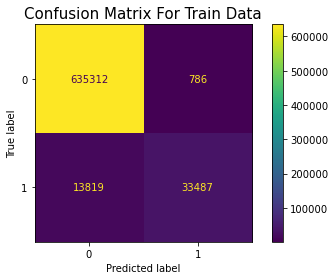

In [18]:
metrics.ConfusionMatrixDisplay.from_estimator(
    estimator=logistic_pipe, X=X_train, y=y_train
)
plt.title("Confusion Matrix For Train Data", size=15)
plt.tight_layout()
plt.show()

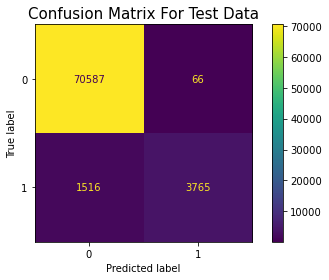

In [19]:
metrics.ConfusionMatrixDisplay.from_estimator(
    estimator=logistic_pipe, X=X_test, y=y_test
)
plt.title("Confusion Matrix For Test Data", size=15)
plt.tight_layout()
plt.show()

### Plot ROC AUC

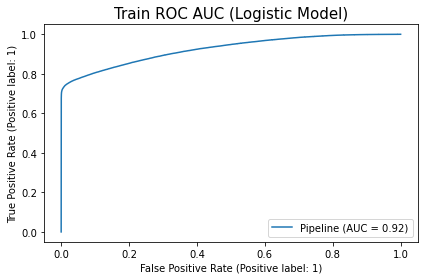

In [20]:
metrics.RocCurveDisplay.from_estimator(estimator=logistic_pipe, X=X_train, y=y_train)
plt.title("Train ROC AUC (Logistic Model)", size=15)
plt.tight_layout()
plt.show()

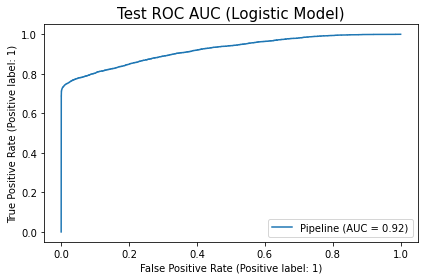

In [21]:
metrics.RocCurveDisplay.from_estimator(estimator=logistic_pipe, X=X_test, y=y_test)
plt.title("Test ROC AUC (Logistic Model)", size=15)
plt.tight_layout()
plt.show()

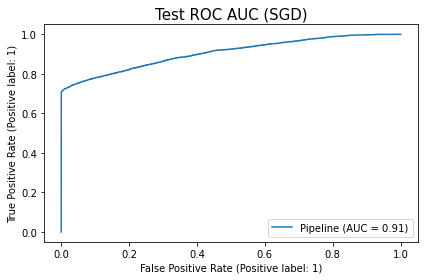

In [22]:
metrics.RocCurveDisplay.from_estimator(estimator=sgd_pipe, X=X_test, y=y_test)
plt.title("Test ROC AUC (SGD)", size=15)
plt.tight_layout()
plt.show()

In [23]:
# Persit the model
fp = "../models/clf_model.joblib"

with open(fp, "wb") as file:
    joblib.dump(value=logistic_pipe, filename=file)